In [1]:
"""
Load:
  x_a_init.txt
Save:
  x_b.txt
  x_a.txt
"""
import numpy as np
from scipy.integrate import ode
import lorenz96
import lorenz96_F
import matplotlib.pyplot as plt
from settings import *

In [2]:
def locallization(B):
    W = np.zeros([40,40])
    L = 10
    
    for i in range(40):
        for j in range(40):
            d_i = np.mod(np.abs(i+40-j),40)
            d_j = np.mod(np.abs(j+40-i),40)
            d = np.min([d_i,d_j])
            W[i,j] = np.exp(-1*d**2/2/L**2)

    return np.multiply(W,B)

In [6]:
nT = 800
nk = 20
#set random seed
np.random.seed(201910)

#load true value
x_t_save = np.genfromtxt('x_t_Fperturbed.txt')

# load initial condition
x_a_init = np.genfromtxt('x_a_init.txt')

analysis_error = 25.e-2
#load background error covariance matrix
B = np.genfromtxt('B.txt')
print("input B", np.trace(B))
np.random.seed(20191031)
# create observations

observation_error = 25.e-2
y_o_save = np.zeros([nT+1, N])
y_o_save = x_t_save + observation_error * np.random.randn(nT+1, N)

x_b_save = np.array([x_a_init])

x_a_save = np.array([x_a_init])
#print("x_a_save shape = ",x_a_save.shape)

tt = 0
R = 0.25 * np.identity(40) #observation error covariance

#B_temp_2 = B.copy()
#B_a = np.reshape(B_temp_2,[40,40,1])
#B_f = np.reshape(B_temp_2,[40,40,1])
H = np.identity(40)
x_b_k_collect_save = []

while tt <=nT:
    ttf = tt + 1
    Ta = tt  * dT  # forecast start time(DA time)
    Tf = ttf * dT  # forecast end time
    print('Cycle =', tt, ', Ta =', round(Ta, 10), ', Tf =', round(Tf, 10))
    # background
    if tt == 0:
        K_i = np.dot(B, np.dot(H, np.linalg.inv(np.dot(H, np.dot(B, H))+R)))
        K = np.reshape(K_i, [1,40,40])
        x_b = x_b_save[tt].transpose()
    else:
        k_i = np.split(K, ttf)[tt]
        x_b_k_slice = np.reshape(np.split(x_b_k_collect_save, ttf-1)[tt-1], [nk,40])
    
    for e in range(nk):
        #--------------
        # analysis step
        #--------------
        np.random.seed(20181130 - e - 2*tt)
        if tt==0:

            E_e = 0.25 #initial ensamble error
            x_b = x_b.copy() + E_e * np.random.randn(N)
        else:
            x_b  = np.reshape(np.split(x_b_k_slice, nk)[e],[40])
        
        
        # observation
        y_o = y_o_save[tt].transpose()
        # perturb observation
        np.random.seed(20191130 + e + 5*tt)
        y_o_k = y_o + observation_error * np.random.randn(N)
        
        # innovation
        y_b = np.dot(H, x_b)
        d = y_o_k - y_b
        x_a = x_b + np.dot(K_i, d)
        if e == 0:
            x_a_k_save = np.reshape(x_a.transpose(),[1,40])
        else:
            x_a_k_save = np.vstack([x_a_k_save, np.reshape(x_a,[1,40])])
        #--------------
        # forecast step
        #--------------
        solver = ode(lorenz96_F.f).set_integrator('dopri5')
        solver.set_initial_value(x_a.transpose() , Ta).set_f_params(F)
        solver.integrate(Tf)
        if e == 0:
            x_b_k_save = np.array([solver.y])
        else:
            x_b_k_save = np.vstack([x_b_k_save, [solver.y]])
    if tt == 0:
        x_b_k_collect_save = np.reshape(x_b_k_save, [1,nk,40])
    else:
        x_b_k_collect_save = np.vstack([x_b_k_collect_save, [x_b_k_save]])

    x_a_k_mean = np.mean(x_a_k_save, axis = 0)
    x_b_k_mean = np.mean(x_b_k_save, axis = 0)
    x_b_save = np.vstack([x_b_save, x_b_k_mean])
    x_a_save = np.vstack([x_a_save, x_a_k_mean])
    #do the poll
    
    PH = np.cov(x_b_k_save, rowvar = False)
    HPH = np.cov(x_b_k_save, rowvar = False)
    
    print("PH = ", np.trace(PH))
    K_ip1 = np.dot(locallization(PH), np.linalg.inv(locallization(HPH)+R))
    print("K = ", np.trace(K_ip1))
    K = np.concatenate((K, np.reshape(K_ip1,[1,40,40])), axis = 0)
    #print(np.trace(HPH))
    tt += 1

#save background and analysis data
print(x_b_save.shape)
print(x_a_save.shape)
x_b_save = x_b_save[0:801][:].copy()
x_a_save = x_a_save[1:802][:].copy()

#np.savetxt('x_b_k200_l10_modelerror0.08.txt', x_b_save)
#np.savetxt('x_a_k200_l10_modelerror0.08.txt', x_a_save)

input B 3.3760000000000003
Cycle = 0 , Ta = 0.0 , Tf = 0.05
PH =  4.878512462654285
K =  6.500927635520469
Cycle = 1 , Ta = 0.05 , Tf = 0.1
PH =  3.0193250258016278
K =  5.061315706553778
Cycle = 2 , Ta = 0.1 , Tf = 0.15
PH =  2.013366202160627
K =  4.01702264758108
Cycle = 3 , Ta = 0.15 , Tf = 0.2
PH =  1.3593616050543509
K =  3.206574111861908
Cycle = 4 , Ta = 0.2 , Tf = 0.25
PH =  0.9602625826640758
K =  2.6834161940245007
Cycle = 5 , Ta = 0.25 , Tf = 0.3
PH =  0.7557423006480856
K =  2.3425749629570705
Cycle = 6 , Ta = 0.3 , Tf = 0.35
PH =  0.606680853607545
K =  1.98533548974886
Cycle = 7 , Ta = 0.35 , Tf = 0.4
PH =  0.5349353068601563
K =  1.8110544251475227
Cycle = 8 , Ta = 0.4 , Tf = 0.45
PH =  0.4900186714794178
K =  1.6810881074403672
Cycle = 9 , Ta = 0.45 , Tf = 0.5
PH =  0.45438853236516386
K =  1.5459355063205358
Cycle = 10 , Ta = 0.5 , Tf = 0.55
PH =  0.46557710895995785
K =  1.5523834658282756
Cycle = 11 , Ta = 0.55 , Tf = 0.6
PH =  0.4553493258049798
K =  1.496723369780

PH =  0.5363421239836806
K =  1.6505045481447929
Cycle = 100 , Ta = 5.0 , Tf = 5.05
PH =  0.5723636903924929
K =  1.740966273421749
Cycle = 101 , Ta = 5.05 , Tf = 5.1
PH =  0.5664407220142931
K =  1.739713526520445
Cycle = 102 , Ta = 5.1 , Tf = 5.15
PH =  0.532442030133371
K =  1.6823875637431747
Cycle = 103 , Ta = 5.15 , Tf = 5.2
PH =  0.48522208931151467
K =  1.5794251144614182
Cycle = 104 , Ta = 5.2 , Tf = 5.25
PH =  0.44394225189255404
K =  1.4696412966701333
Cycle = 105 , Ta = 5.25 , Tf = 5.3
PH =  0.42483974809281677
K =  1.411516578852789
Cycle = 106 , Ta = 5.3 , Tf = 5.35
PH =  0.41962144807987906
K =  1.4009883684483784
Cycle = 107 , Ta = 5.35 , Tf = 5.4
PH =  0.4129910360321831
K =  1.4025037028993035
Cycle = 108 , Ta = 5.4 , Tf = 5.45
PH =  0.4085491198902885
K =  1.4123434789417186
Cycle = 109 , Ta = 5.45 , Tf = 5.5
PH =  0.40649724038511814
K =  1.431698043542489
Cycle = 110 , Ta = 5.5 , Tf = 5.55
PH =  0.3863600614168303
K =  1.383583323050019
Cycle = 111 , Ta = 5.55 , Tf

PH =  0.4949486511164285
K =  1.6749152983348214
Cycle = 198 , Ta = 9.9 , Tf = 9.95
PH =  0.48043326162876365
K =  1.6330474224444531
Cycle = 199 , Ta = 9.95 , Tf = 10.0
PH =  0.48135439261692436
K =  1.6490173238565369
Cycle = 200 , Ta = 10.0 , Tf = 10.05
PH =  0.4739872604496187
K =  1.6310916164715317
Cycle = 201 , Ta = 10.05 , Tf = 10.1
PH =  0.45705953569009816
K =  1.572404210696511
Cycle = 202 , Ta = 10.1 , Tf = 10.15
PH =  0.4544371326808288
K =  1.5629445890518043
Cycle = 203 , Ta = 10.15 , Tf = 10.2
PH =  0.4370471127233412
K =  1.5070580145381272
Cycle = 204 , Ta = 10.2 , Tf = 10.25
PH =  0.431003974998836
K =  1.476483282765253
Cycle = 205 , Ta = 10.25 , Tf = 10.3
PH =  0.4179675968245524
K =  1.4415024649532708
Cycle = 206 , Ta = 10.3 , Tf = 10.35
PH =  0.4168215261085658
K =  1.4405546872984414
Cycle = 207 , Ta = 10.35 , Tf = 10.4
PH =  0.4183628052808842
K =  1.4541538454111773
Cycle = 208 , Ta = 10.4 , Tf = 10.45
PH =  0.410084112664151
K =  1.443267409001662
Cycle = 20

K =  1.8825184570677196
Cycle = 293 , Ta = 14.65 , Tf = 14.7
PH =  0.6302215103619726
K =  1.9371446434991675
Cycle = 294 , Ta = 14.7 , Tf = 14.75
PH =  0.6321601681694253
K =  1.940910905997082
Cycle = 295 , Ta = 14.75 , Tf = 14.8
PH =  0.6256331028329679
K =  1.914024928897586
Cycle = 296 , Ta = 14.8 , Tf = 14.85
PH =  0.6921159797069087
K =  2.0014795355878614
Cycle = 297 , Ta = 14.85 , Tf = 14.9
PH =  0.7603985750990416
K =  2.064536177323683
Cycle = 298 , Ta = 14.9 , Tf = 14.95
PH =  0.7917012866043394
K =  2.0954469349354854
Cycle = 299 , Ta = 14.95 , Tf = 15.0
PH =  0.7298784003641539
K =  1.9929806609398804
Cycle = 300 , Ta = 15.0 , Tf = 15.05
PH =  0.629133567781968
K =  1.8802352885032452
Cycle = 301 , Ta = 15.05 , Tf = 15.1
PH =  0.5611243031014937
K =  1.7865672926365965
Cycle = 302 , Ta = 15.1 , Tf = 15.15
PH =  0.5402893163172928
K =  1.7663544275624086
Cycle = 303 , Ta = 15.15 , Tf = 15.2
PH =  0.5474761825450085
K =  1.794924241694952
Cycle = 304 , Ta = 15.2 , Tf = 15.2

PH =  0.5223056048663388
K =  1.6719978528837245
Cycle = 390 , Ta = 19.5 , Tf = 19.55
PH =  0.530178552053955
K =  1.6821844818472083
Cycle = 391 , Ta = 19.55 , Tf = 19.6
PH =  0.5032944588220034
K =  1.6241380710332929
Cycle = 392 , Ta = 19.6 , Tf = 19.65
PH =  0.4875316058551896
K =  1.601078967213851
Cycle = 393 , Ta = 19.65 , Tf = 19.7
PH =  0.5022973115202414
K =  1.6820731285484611
Cycle = 394 , Ta = 19.7 , Tf = 19.75
PH =  0.5121079535610191
K =  1.7178339655099855
Cycle = 395 , Ta = 19.75 , Tf = 19.8
PH =  0.5075319146000739
K =  1.7003339322498934
Cycle = 396 , Ta = 19.8 , Tf = 19.85
PH =  0.46289048471113337
K =  1.5903541525275002
Cycle = 397 , Ta = 19.85 , Tf = 19.9
PH =  0.42400024748068516
K =  1.4877500652387026
Cycle = 398 , Ta = 19.9 , Tf = 19.95
PH =  0.4081600761943142
K =  1.4322590710749417
Cycle = 399 , Ta = 19.95 , Tf = 20.0
PH =  0.4043783642764164
K =  1.4080459295717316
Cycle = 400 , Ta = 20.0 , Tf = 20.05
PH =  0.4140952089061584
K =  1.4383804072601967
Cycle

PH =  0.6637073444446027
K =  1.9619146992020093
Cycle = 487 , Ta = 24.35 , Tf = 24.4
PH =  0.6875915214175748
K =  2.0006434190003524
Cycle = 488 , Ta = 24.4 , Tf = 24.45
PH =  0.6999949288866721
K =  2.015491966368389
Cycle = 489 , Ta = 24.45 , Tf = 24.5
PH =  0.7223580968076918
K =  2.0843781192660993
Cycle = 490 , Ta = 24.5 , Tf = 24.55
PH =  0.7413509995501268
K =  2.158324440371832
Cycle = 491 , Ta = 24.55 , Tf = 24.6
PH =  0.7076884229516347
K =  2.1656298785095043
Cycle = 492 , Ta = 24.6 , Tf = 24.65
PH =  0.6344584393688961
K =  2.0490068545371027
Cycle = 493 , Ta = 24.65 , Tf = 24.7
PH =  0.5635287058876521
K =  1.8797956587969518
Cycle = 494 , Ta = 24.7 , Tf = 24.75
PH =  0.503060707386811
K =  1.7240087546057032
Cycle = 495 , Ta = 24.75 , Tf = 24.8
PH =  0.43785610433659683
K =  1.539743789938881
Cycle = 496 , Ta = 24.8 , Tf = 24.85
PH =  0.42811203858019653
K =  1.5047697315356396
Cycle = 497 , Ta = 24.85 , Tf = 24.9
PH =  0.44023281404223835
K =  1.5244001368396605
Cycle 

PH =  0.3797964302001937
K =  1.3440924673884038
Cycle = 584 , Ta = 29.2 , Tf = 29.25
PH =  0.40847912743003834
K =  1.433155855602491
Cycle = 585 , Ta = 29.25 , Tf = 29.3
PH =  0.4398469091396499
K =  1.5195682272793436
Cycle = 586 , Ta = 29.3 , Tf = 29.35
PH =  0.45960616419992695
K =  1.5685784326395549
Cycle = 587 , Ta = 29.35 , Tf = 29.4
PH =  0.4892807977003881
K =  1.6446379889963452
Cycle = 588 , Ta = 29.4 , Tf = 29.45
PH =  0.49020347160253913
K =  1.6404188520111247
Cycle = 589 , Ta = 29.45 , Tf = 29.5
PH =  0.49241958823318954
K =  1.6535282427809372
Cycle = 590 , Ta = 29.5 , Tf = 29.55
PH =  0.49510724318404414
K =  1.658514486796057
Cycle = 591 , Ta = 29.55 , Tf = 29.6
PH =  0.4890934219090707
K =  1.6433630646503752
Cycle = 592 , Ta = 29.6 , Tf = 29.65
PH =  0.48439691263676216
K =  1.6406207733336098
Cycle = 593 , Ta = 29.65 , Tf = 29.7
PH =  0.4484176631742053
K =  1.5399142754787618
Cycle = 594 , Ta = 29.7 , Tf = 29.75
PH =  0.4332139141301746
K =  1.4925489139090997
C

PH =  0.47440398551069696
K =  1.6176585795288385
Cycle = 680 , Ta = 34.0 , Tf = 34.05
PH =  0.4864541712316776
K =  1.627676090766108
Cycle = 681 , Ta = 34.05 , Tf = 34.1
PH =  0.5239997980531268
K =  1.692917600211037
Cycle = 682 , Ta = 34.1 , Tf = 34.15
PH =  0.5256530931369396
K =  1.6986968218049057
Cycle = 683 , Ta = 34.15 , Tf = 34.2
PH =  0.5244590083284497
K =  1.7152730081334915
Cycle = 684 , Ta = 34.2 , Tf = 34.25
PH =  0.5352759528151576
K =  1.749446158955568
Cycle = 685 , Ta = 34.25 , Tf = 34.3
PH =  0.5499843824381233
K =  1.8014791605366158
Cycle = 686 , Ta = 34.3 , Tf = 34.35
PH =  0.550253862800365
K =  1.8221015005378776
Cycle = 687 , Ta = 34.35 , Tf = 34.4
PH =  0.5142387117687534
K =  1.7316215818044847
Cycle = 688 , Ta = 34.4 , Tf = 34.45
PH =  0.4941831964517009
K =  1.6610733861961244
Cycle = 689 , Ta = 34.45 , Tf = 34.5
PH =  0.4942952920458162
K =  1.6491269257116907
Cycle = 690 , Ta = 34.5 , Tf = 34.55
PH =  0.4700902337108016
K =  1.5896348965779399
Cycle = 

K =  1.799212700460091
Cycle = 776 , Ta = 38.8 , Tf = 38.85
PH =  0.549872048633951
K =  1.8137812009072576
Cycle = 777 , Ta = 38.85 , Tf = 38.9
PH =  0.5544808903619092
K =  1.8241433773927211
Cycle = 778 , Ta = 38.9 , Tf = 38.95
PH =  0.5653564740974992
K =  1.831236691423977
Cycle = 779 , Ta = 38.95 , Tf = 39.0
PH =  0.5869069764504303
K =  1.834501817998358
Cycle = 780 , Ta = 39.0 , Tf = 39.05
PH =  0.6274087966915782
K =  1.8757342440836542
Cycle = 781 , Ta = 39.05 , Tf = 39.1
PH =  0.6296547379302537
K =  1.8636932872800742
Cycle = 782 , Ta = 39.1 , Tf = 39.15
PH =  0.6082348404539161
K =  1.8761782306709642
Cycle = 783 , Ta = 39.15 , Tf = 39.2
PH =  0.5933130425708002
K =  1.8792426752511573
Cycle = 784 , Ta = 39.2 , Tf = 39.25
PH =  0.5979517708632757
K =  1.9262010915751082
Cycle = 785 , Ta = 39.25 , Tf = 39.3
PH =  0.5665860334497215
K =  1.851951482471056
Cycle = 786 , Ta = 39.3 , Tf = 39.35
PH =  0.5394250764875237
K =  1.76753074891796
Cycle = 787 , Ta = 39.35 , Tf = 39.4


In [4]:
N = 40
bias_v = []
rmse_v = []
for i in range(N):
    pt = i
    plt.figure()
    #print(x_a_save[:,pt-1])
    #print(x_b_save[:,pt-1])
    
    plt.plot(np.arange(nT+1) * dT, x_t_save[:,pt-1], 'k+--', label=r'$x^t_{' + str(pt) + '}$')
    plt.plot(np.arange(nT+1) * dT, x_b_save[:,pt-1], 'go-' , label=r'$x^b_{' + str(pt) + '}$')
    plt.plot(np.arange(nT+1) * dT, x_a_save[:,pt-1], 'bo-' , label=r'$x^a_{' + str(pt) + '}$')
    bias_i = (x_b_save[30:,pt-1]-x_t_save[30:,pt-1]).mean()
    #print("bias = ", bias_i)
    rmse_i = np.std(x_b_save[30:,pt-1]-x_t_save[30:,pt-1])
    #print("rmse = ", rmse_i)
    bias_v.append(bias_i)
    rmse_v.append(rmse_i)
    
    plt.xlabel(r'$t$', size=18)
    plt.ylabel(r'$x$', size=18)
    plt.xlim(0,3)
    plt.title(r'Time series of $x_{' + str(pt) + '}$', size=20)
    plt.legend(loc='upper right', numpoints=1, prop={'size':18})
    plt.savefig('timeseries.png', dpi=200)
    #plt.show()
    plt.close()
print("bias=", np.mean(bias_v))
print("rmse=", np.mean(rmse_v))

bias= -0.1712595778354244
rmse= 0.296538059240675


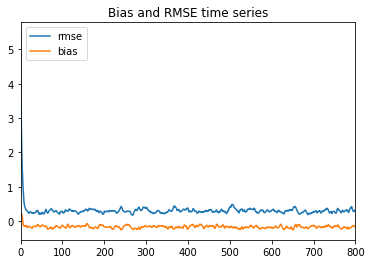

rmse= 0.2928646051158117
bias= -0.17133501721118313


In [5]:
analysis_error = x_b_save-x_t_save
bias_t = []
rmse_t = []
for i in range(nT):
    
    bias_i = analysis_error[i][:].mean()
    rmse_i = np.std(analysis_error[i][:])
    bias_t = np.append(bias_t, bias_i)
    rmse_t = np.append(rmse_t, rmse_i)

plt.plot(rmse_t, label ="rmse" )
plt.plot(bias_t, label ="bias")
#plt.ylim(-0.3,0.4)
plt.xlim(0,800)
plt.legend(loc="upper left")
plt.title("Bias and RMSE time series")
plt.show()
rmse = rmse_t[30:800].mean()
bias = bias_t[30:800].mean()
print("rmse=",rmse)
print("bias=",bias)
#np.savetxt('ENKF_k200_l10_modelerror0.08_bias.txt',bias_t)
#np.savetxt('ENKF_k200_l10_modelerror0.08_rmse.txt',rmse_t)

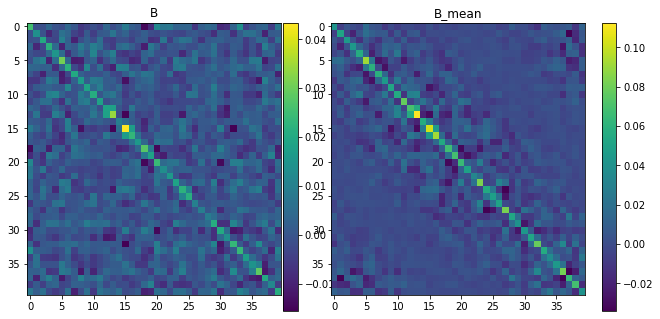

In [11]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
ax.set_title('B')
plt.imshow(HPH)
ax.set_aspect('auto')
cax = fig.add_axes([0.26, 0.08, 0.26, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

ax2 = fig.add_subplot(122)
ax2.set_title('B_mean')
plt.imshow(np.reshape(k_i,[40,40]))
ax2.set_aspect('auto')

cax = fig.add_axes([0.26, 0.08, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

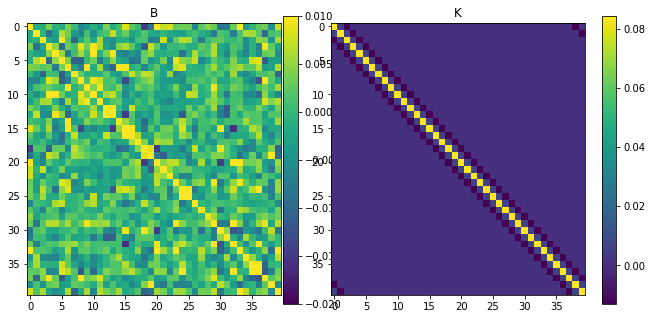

In [12]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
ax.set_title('B')
plt.imshow(HPH,vmin=-0.02,vmax=0.01)
ax.set_aspect('auto')
cax = fig.add_axes([0.26, 0.1, 0.26, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

ax2 = fig.add_subplot(122)
ax2.set_title('K')
plt.imshow(B)
ax2.set_aspect('auto')

cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

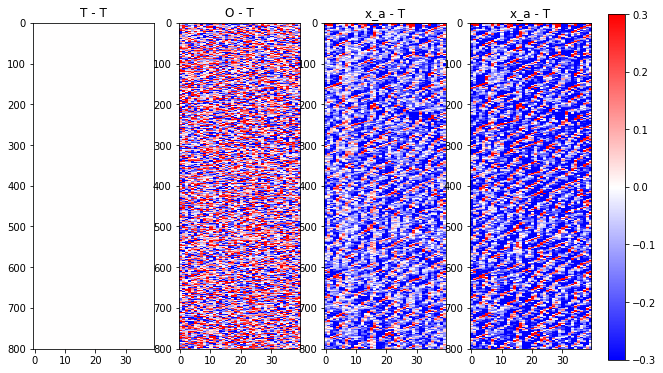

In [28]:
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(141)
ax.set_title('T - T')
plt.imshow(x_t_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax.set_aspect('auto')

ax2 = fig.add_subplot(142)
ax2.set_title('O - T')
plt.imshow(y_o_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax2.set_aspect('auto')


ax3 = fig.add_subplot(143)
ax3.set_title('x_a - T')
plt.imshow(x_a_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax3.set_aspect('auto')


ax4 = fig.add_subplot(144)
ax4.set_title('x_a - T')
plt.imshow(x_b_save[0:801][:]-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax4.set_aspect('auto')


cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

In [29]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(xlim=(0, 40), ylim=(0, 40))

ax.set_title('B')
ax.set_aspect('auto')

#line, = ax.plot([], [], lw=2)
a = np.random.random((40,40))
im = plt.imshow(a,interpolation='none', vmin=-0.02, vmax =0.06)
# initialization function: plot the background of each frame
def init():
    im.set_data(np.random.random((40,40)))
           
    cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    plt.colorbar(orientation='vertical')
    
    return [im]

# animation function.  This is called sequentially
def animate(i):

    a = np.reshape(np.split(K,ttf+1)[i], [40,40])
    im.set_array(a)

    return [im]

In [30]:
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=200, interval=10, blit=True)
anim.save('basic_animation.mp4', fps=12, extra_args=['-vcodec', 'libx264'])
plt.show()

NameError: name 'animation' is not defined

In [64]:
"""
Definition of the Lorenz 40-variable (Lorenz 96) model
"""
import numpy as np

def f(t, y, F):
    
    
    #F = F + error_of_F * np.random.randn(y.size) # test
    return (np.roll(y, -1) - np.roll(y, 2)) * np.roll(y, 1) - y + F

In [65]:
np.random.seed(21010+1)
y = np.array([2,3,4,5])
print(f(1,y,F + error_of_F *np.random.randn()))

[ 1.9417204  3.9417204 13.9417204 -0.0582796]
